# Camera Calibration
To correctly transform the turbine as it is placed into the Google Street View image, the camera matrix needs to be derived, which calculates the neccessary transformations required to to convert between the camera coordinate system and the global coordinate system

In [1]:
%matplotlib widget
from utils import intrinsic_parameters, rotation_matrix, extrinsic_parameters, camera_matrix, image_plane
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np


To establish a coherent framework, we begin by defining the global coordinate system. In this context, a right-handed coordinate system is employed, wherein positive changes in the x-axis represent longitudinal shifts, positive changes in the y-axis denote latitudinal shifts, and positive changes in the z-direction signify an increase in elevation. 
<br> ![title](../jupyter-book/images/coord_sys.png)

## Intrinsic parameters
$K = \begin{bmatrix}
\alpha_x & \gamma & u_0 & 0\\
0 & \alpha_y & v_0 & 0\\
0 & 0 & 1 & 0
\end{bmatrix}$

The $K$ matrix comprises five intrinsic parameters specific to the camera model being used. These parameters encompass essential factors such as the focal length, image sensor format, and camera principal point.

Two of these parameters, $\alpha_x = f \cdot m_x$ and $\alpha_y = f \cdot m_y$, express the focal length in terms of pixels. Here, $m_x$ and $m_y$ represent the inverses of the width and height of a pixel on the projection plane, while $f$ denotes the focal length measured in terms of distance. The skew coefficient between the x and y axes, denoted as $\gamma$, is typically assumed to be 0. The parameters $u_0$ and $v_0$ represent the principal point, ideally located at the center of the image.


In [2]:
f = 0.02 # focal length
shape = [250, 250] # shape of image in pixels
fov = [60, 60]

K = intrinsic_parameters(f, shape, fov)

print(K)

[[216.50635095   0.         125.        ]
 [  0.         216.50635095 125.        ]
 [  0.           0.           1.        ]]


## Rotation Matrix
A rotation matrix serves as a transformation matrix employed to execute rotations in space. It facilitates the determination of the necessary rotations for converting between the real-world coordinate system and the camera coordinates by utilizing Euler angles. For instance, following the convention below, the matrix plays a crucial role in this process.

https://en.wikipedia.org/wiki/Rotation_matrix

In [3]:
roll = np.deg2rad(90) # roll (X)
pitch = np.deg2rad(0) # tilt (Y)
yaw = np.deg2rad(0) # direction (Z)

theta = np.array([roll, pitch, yaw]) 

R = rotation_matrix(theta, order = "YZX")

print (R)

[[ 1.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  6.123234e-17]]


https://en.wikipedia.org/wiki/3D_projection#Perspective_projection

Normalized camera matrix, $C_N = R (I | -ñ)$

In [4]:
n = np.array([0, 0, 0]) # 3D translation of camera origin and world origin

C_N = extrinsic_parameters(R, n)

P = camera_matrix(K, C_N)


Let's test the functions by defining a point in 3D space.

In [5]:
turbine_origin = [0, 1, 0]


u, v = image_plane(P, turbine_origin)

print(f"U: {u:.1f} px\nV: {v:.1f} px")

U: 125.0 px
V: 125.0 px


In [6]:
# INPUTS
f = 0.1 # focal length
shape = [250, 250] # shape of image in pixels
fov = [90, 90]
K = intrinsic_parameters(f, shape, fov)
theta = -np.array([np.deg2rad(0), np.deg2rad(180), np.deg2rad(0)])
R = rotation_matrix(theta, order = "ZYX")
camera_origin = np.array([5, 5, 2]) # 3D translation of camera origin and world origin
C_N = extrinsic_parameters(R, camera_origin)
P = camera_matrix(K, C_N)
turbine_origin = np.array([10, 10, -20])
u, v = image_plane(P, turbine_origin)
print(u,v)

96.59090909090911 153.4090909090909


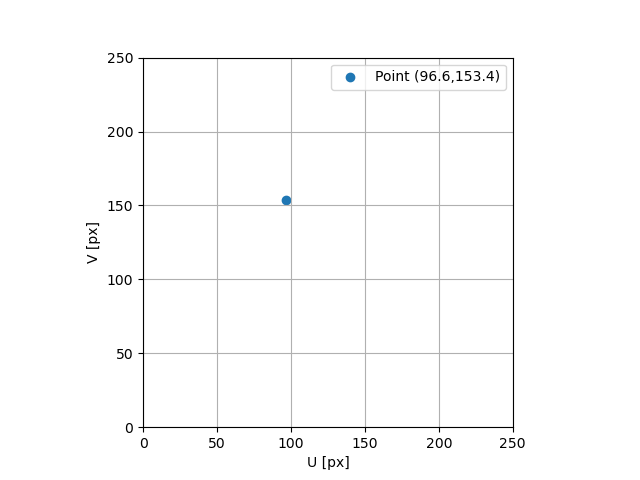

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(u, v, label = f"Point ({u:.1f},{v:.1f})")
ax.set(xlim = [0, shape[0]], 
       ylim = [0, shape[1]],
       xlabel = "U [px]",
       ylabel = "V [px]",
       aspect = "equal")
ax.grid()
ax.legend()
plt.show()

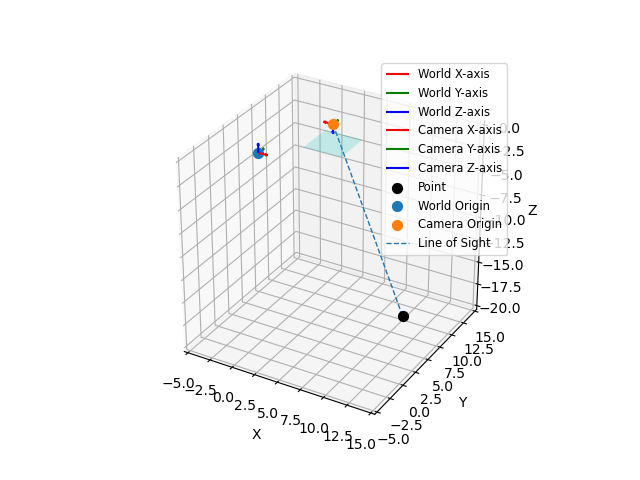

In [8]:
# Create a 3D plot
theta *= -1
R = rotation_matrix(theta, order = "XYZ")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the origin for world coordinates and unit vectors along the world coordinates
world_origin = [0, 0, 0]
world_x_vector = [1, 0, 0]
world_y_vector = [0, 1, 0]
world_z_vector = [0, 0, 1]

# Define the origin for camera coordinates and unit vectors along the camera coordinates
camera_x_vector = R @ world_x_vector
camera_y_vector = R @ world_y_vector 
camera_z_vector = R @ world_z_vector

# Plot the world coordinate system with labels
ax.quiver(*world_origin, *world_x_vector, color='r', label='World X-axis')
ax.quiver(*world_origin, *world_y_vector, color='g', label='World Y-axis')
ax.quiver(*world_origin, *world_z_vector, color='b', label='World Z-axis')

# Plot the camera coordinate system with labels
ax.quiver(*camera_origin, *camera_x_vector, color='r', label='Camera X-axis')
ax.quiver(*camera_origin, *camera_y_vector, color='g', label='Camera Y-axis')
ax.quiver(*camera_origin, *camera_z_vector, color='b', label='Camera Z-axis')

# Plot the 3D point with a label
ax.scatter(*turbine_origin, c='k', s=50, label='Point')
ax.scatter(*world_origin, s=50, label = "World Origin")
ax.scatter(*camera_origin, s=50, label = "Camera Origin")

#### INPUTS #####
f = 2
vfov = np.deg2rad(90)
hfov = np.deg2rad(90)

vl = 2*np.tan(vfov/2)*f # vertical length
hl = 2*np.tan(hfov/2)*f # horizontal length
zz = f *np.ones([2, 2]) # offset in z
xx, yy = np.meshgrid(np.linspace(-hl/2, hl/2, 2), np.linspace(-vl/2, vl/2, 2))
coord = np.einsum('ij,kj->ki', R, np.c_[xx.ravel(), yy.ravel(), zz.ravel()]) + camera_origin
# ax.scatter(*coord.T)
vertices = [coord[[0, 1, 3]], coord[[0, 2, 3]]]
surface = Poly3DCollection(vertices, alpha=0.2)
surface.set_facecolor('c')
ax.add_collection3d(surface)

ax.plot(*np.array([camera_origin, turbine_origin]).T, linestyle = "dashed", linewidth = 1, label = "Line of Sight")

s = 1
arr = np.array([world_origin, camera_origin, turbine_origin])
min = np.min(arr)/s-1
max = np.max(arr)*s+1
# # min_coord = np.min(arr, axis=0)/s-1
# # max_coord = np.max(arr, axis=0)*s+1

ax.scatter(*-np.array([max]*3)+world_origin, alpha = 0)
ax.scatter(*np.array([max]*3)+world_origin, alpha = 0)

offset = camera_origin - turbine_origin
l = np.sqrt(np.sum(offset**2))

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# set range of plot
coords = np.array([world_origin, turbine_origin])
center = np.mean(coords, axis=0)
max_range = np.max(np.ptp(coords, axis=0))
ax.set_xlim(center[0] - max_range/2, center[0] + max_range/2)
ax.set_ylim(center[1] - max_range/2, center[1] + max_range/2)
ax.set_zlim(center[2] - max_range/2, center[2] + max_range/2)

ax.set_aspect('equal')
ax.legend(fontsize='small')
plt.show()

![Alt text](image.png)

320.0 320.0


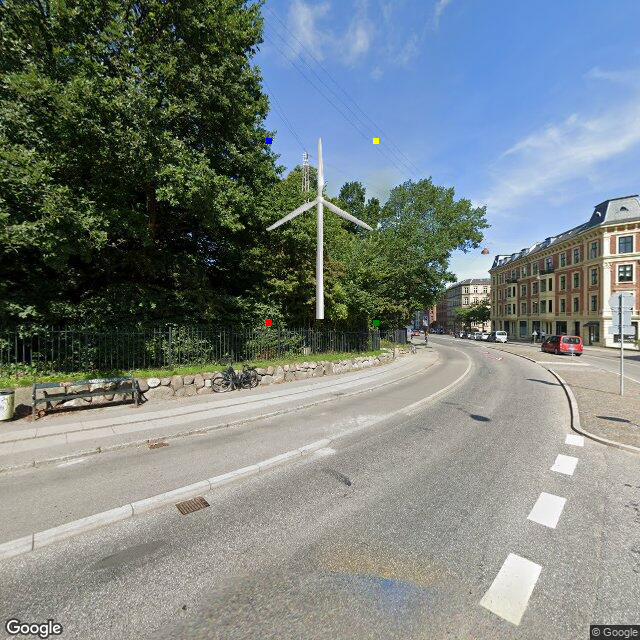

In [10]:
from utils import Photo, Turbine, find_coeffs
from PIL import Image, ImageDraw, ImageEnhance
camera_origin = np.array([0, 0, 0]) 
turbine_origin = np.array([10, 0, 0])

# calculate turbine direction
e_y = np.array([1, 0])
angle_vector = (turbine_origin - camera_origin)[:2]
direction = np.arccos((e_y @ angle_vector)/(np.linalg.norm(angle_vector)))

camera_coord = [12.530035398113766, 55.66769631625086]
turbine_coord = [12.533434441656016, 55.66534279150843]
height = 4
roll, tilt, yaw = np.array([90, 0, 90]) # tilt should be 0
pic_class = Photo("../temp/site_img.png", fov[0], tilt, yaw, camera_coord, camera_origin, f)
turb_class = Turbine("../temp/obj2png.png", fov[0], height, turbine_coord, turbine_origin, 0)

f = 1 # focal length
fov = [90, 90]
shape = pic_class.shape
K = intrinsic_parameters(f, shape, fov)
theta = np.array([np.deg2rad(roll), np.deg2rad(tilt), np.deg2rad(yaw)])
R = rotation_matrix(theta, order = "xzy")
C_N = extrinsic_parameters(R, camera_origin)
P = camera_matrix(K, C_N)
u, v = image_plane(P, turbine_origin)
print(u,v)

radius = turb_class.radius

point1 = np.array([-np.sin(direction)*radius, np.cos(direction)*radius, 0]) + turbine_origin
point2 = np.array([np.sin(direction)*radius, -np.cos(direction)*radius, 0]) + turbine_origin
point3= np.array([-np.sin(direction)*radius, np.cos(direction)*radius, height+radius]) + turbine_origin
point4 = np.array([np.sin(direction)*radius, -np.cos(direction)*radius, height+radius]) + turbine_origin

p_list = [point1, point2, point3, point4]

draw = ImageDraw.Draw(pic_class.im)
pa = []
for i, p in enumerate(p_list):
    u, v = image_plane(P, p)
    colors = ["red", "green", "blue", "yellow"]
    d = draw.rectangle(((u,v),(u+5,v+5)),fill = colors[i])
    pa.append([u,v])

pc = np.array(pa).reshape(4,2)
pc[:,0] -= np.amin(pc[:,0])
pc[:,1] -= np.amin(pc[:,1])

pb = [(turb_class.shape[1], turb_class.shape[0]), (0, turb_class.shape[0]),  (turb_class.shape[1], 0), (0, 0)]

pd = list(pa)
for i in range(len(pa)):
    pa[i] = [pc[i,0],pc[i,1]]
    
coeffs = find_coeffs(pa, pb)

turb_class.im = turb_class.im.transform((int(np.amax(np.array(pa).reshape(4,2)[:,0])),int(np.amax(np.array(pa).reshape(4,2)[:,1]))), method=Image.Transform.PERSPECTIVE,data=coeffs)
pic_class.im.paste(turb_class.im, box=[np.amin(np.array(pd).reshape(4,2)[:,0]).astype(int),np.amin(np.array(pd).reshape(4,2)[:,1]).astype(int)], mask = turb_class.im)

pic_class.im.show()
display(pic_class.im)